### **Install libraries**
These should be uncommented if it's your first time running the notebook.
On subsequent runs, they should be commented as it wastes time.

In [526]:
# %pip install pandas
# %pip install matplotlib
# %pip install statsmodels
# %pip install pmdarima
# %pip install numpy
# %pip install cython
# %pip install fbprophet
# %pip install pystan

### **Import libraries**

In [527]:
# ===========================================
# Python imports
# ===========================================
import warnings
from datetime import date

# ===========================================
# Third-party imports
# ===========================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pmdarima import auto_arima
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import seaborn

In [528]:
warnings.filterwarnings('ignore')

In [529]:
FILE_PATH = '../../../volza/magnesium/magnesium.csv'
data = pd.read_csv(FILE_PATH)

# Only keep YY-MM-DD
data['Date'] = pd.to_datetime(data['Date'].str.split(' ').str[0])
data.sort_values('Date', inplace=True)

# Set 'Date' as the index
data.set_index('Date', inplace=True)

In [530]:
# Convert columns to numeric, coercing errors (turning non-numeric to NaN)
NUMERIC_COLUMNS = ['Value', 'Unit Rate $', 'Quantity']
# NUMERIC_COLUMNS = ['Value']
for col in NUMERIC_COLUMNS:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Replace zeros with NaN and interpolate
for col in NUMERIC_COLUMNS:
    data[col].replace(0, pd.NA, inplace=True)
    data[col].interpolate(method='linear', inplace=True)

In [531]:
countries = data['Country of Origin'].unique()
countries

array(['Poland', 'Austria', 'Luxembourg', 'Netherlands', 'China', 'Italy',
       'Czech Republic', 'Slovenia', 'Sweden', 'Croatia',
       'United Kingdom', 'Lithuania', 'France', 'Hungary', 'Germany',
       'India', 'Greece', 'Belgium', 'Tunisia', 'Spain', 'Latvia',
       'Israel', 'Romania', 'Denmark', 'United States', 'Russia',
       'Slovakia', 'Taiwan', 'Vietnam', 'Hong Kong', 'South Korea',
       'Portugal', 'Japan', 'Switzerland', 'Saudi Arabia', 'Indonesia',
       'Colombia', 'Panama', 'Turkey', 'Serbia And Montenegro',
       'Bulgaria', nan, 'Mexico', 'Iran', 'United Arab Emirates',
       'Norway', 'Namibia', 'Samoa', 'Peru', 'Cyprus', 'Singapore',
       'Finland', 'Canada', 'Brazil', 'Malta', 'Ireland', 'Estonia',
       'Uzbekistan', 'Chile', 'Morocco', 'Ghana', 'Nigeria', 'Egypt',
       'Venezuela'], dtype=object)

In [532]:
# Countries that will be analyzed
countries_export = ['China']
# countries_export = ['Poland', 'Austria', 'Luxembourg', 'Netherlands', 'China', 'Italy',
#        'Czech Republic', 'Slovenia', 'Sweden', 'Croatia',
#        'United Kingdom', 'Lithuania', 'France', 'Hungary', 'Germany',
#        'India', 'Greece', 'Belgium', 'Tunisia', 'Spain', 'Latvia',
#        'Israel', 'Romania', 'Denmark', 'United States', 'Russia',
#        'Slovakia', 'Taiwan', 'Vietnam', 'Hong Kong', 'South Korea',
#        'Portugal', 'Japan', 'Switzerland', 'Saudi Arabia', 'Indonesia',
#        'Colombia', 'Panama', 'Turkey', 'Serbia And Montenegro',
#        'Bulgaria', 'Mexico', 'Iran', 'United Arab Emirates',
#        'Norway', 'Namibia', 'Samoa', 'Peru', 'Cyprus', 'Singapore',
#        'Finland', 'Canada', 'Brazil', 'Malta', 'Ireland', 'Estonia',
#        'Uzbekistan', 'Chile', 'Morocco', 'Ghana', 'Nigeria', 'Egypt',
#        'Venezuela']

filtered_data = data[(data['Country of Origin'].isin(countries_export))]


# filtered_data = data[(data['Country of Origin'].isin(countries_export)) & 
#                      (data['Country of Destination'].isin(countries_import))]

filtered_data[['Country of Origin', 'Country of Destination', 'Value', 'Unit Rate $', 'Quantity', 'Unit']].head(10)

,Country of Origin,Country of Destination,Value,Unit Rate $,Quantity,Unit
Date,,,,,,
2020-01-01,China,Netherlands,10015044.94,NaN,<NA>,UNT
2020-01-01,China,Vietnam,<NA>,2.47,5000.0,KGS
2020-01-01,China,Hungary,215385.39,NaN,<NA>,UNT
2020-01-01,China,Vietnam,<NA>,2.095,20000.0,KGS
2020-01-01,China,Slovenia,2443624.72,NaN,<NA>,UNT
2020-01-01,China,Italy,573502.25,NaN,<NA>,UNT
2020-01-01,China,Vietnam,<NA>,2275.0,24.0,TNE
2020-01-01,China,Vietnam,<NA>,2275.0,24.0,TNE
2020-01-01,China,Vietnam,<NA>,2.123,21000.0,KGS


In [533]:
grouped_data = filtered_data.groupby('Country of Origin')

In [534]:
# Initialize a dictionary to store the autoregression models and predictions for each country
ar_models = {}
predictions = {}

### **1. Data Visualization**

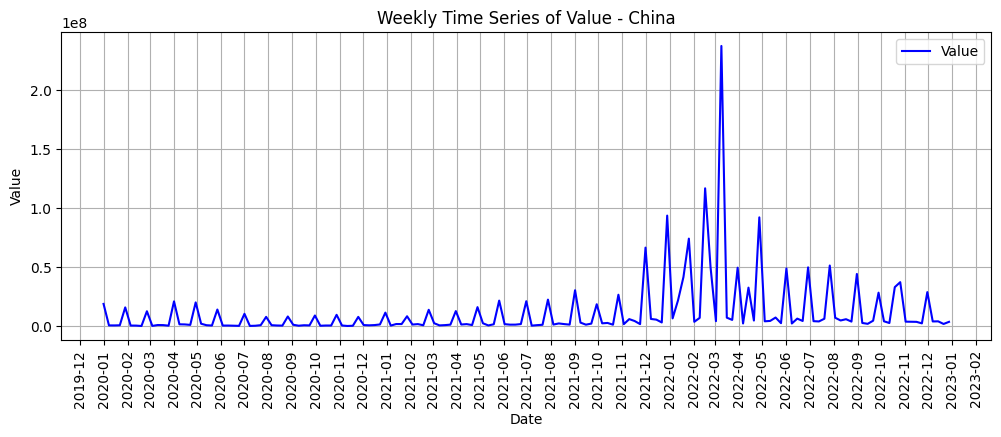

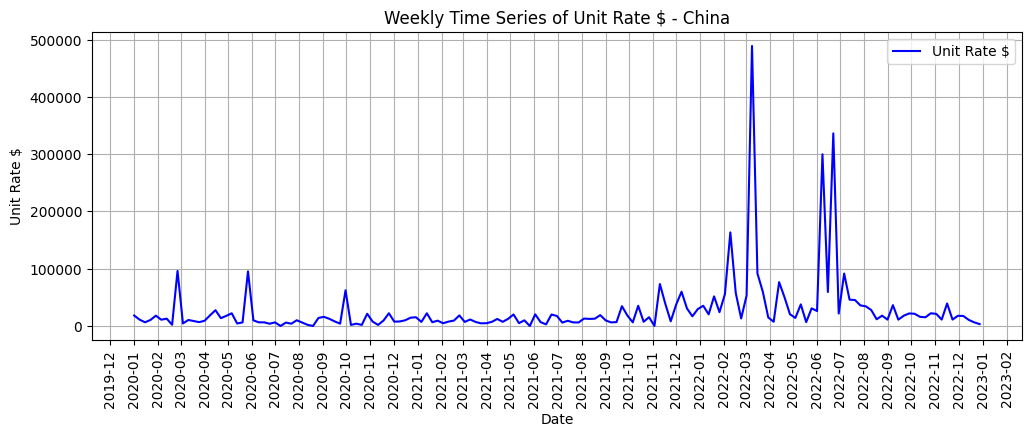

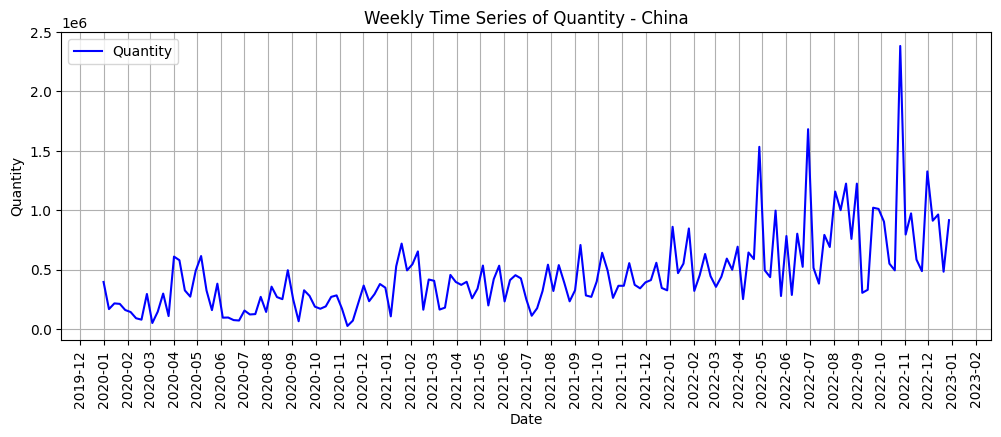

In [535]:
import matplotlib.pyplot as plt

# Plotting time series for each metric and country
for country, group in grouped_data:
    # Resample data and sum 'Value', 'Unit Rate $', and 'Quantity' in weekly increments
    weekly_data = group[['Value', 'Unit Rate $', 'Quantity']].resample('7D').sum()

    # ======================================================
    # 1. Data Visualization
    # ======================================================
    # Plot for 'Value'
    for index, numeric_column in enumerate(NUMERIC_COLUMNS):
        plt.figure(figsize=(12, 4))
        plt.plot(weekly_data.index, weekly_data[numeric_column], label=numeric_column, color='blue')
        plt.title(f'Weekly Time Series of {numeric_column} - {country}')
        plt.xlabel('Date')
        plt.ylabel(numeric_column)
        plt.xticks(rotation=90)
        plt.legend()
        plt.grid(True)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.show()

In [536]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_graph_with_mean(data, column_name: str, ax, rolling_window: int = 7):

    seaborn.lineplot(x=data.index, y=data[column_name], ax=ax, color='dodgerblue')
    seaborn.lineplot(x=data.index, y=data[column_name].rolling(rolling_window).mean(), ax=ax, color='black', label='Rolling Mean')
    seaborn.lineplot(x=data.index, y=data[column_name].rolling(rolling_window).std(), ax=ax, color='orange', label='Rolling Std.')

    ax.set_title(f'Visual test for Stationarity: {column_name}', fontsize=10)
    ax.set_ylabel(ylabel=column_name, fontsize=14)

    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

def visualize_adfuller_results(data, series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
        
    plt.xticks(rotation=45)
    seaborn.lineplot(x=data.index, y=series, ax=ax, color=linecolor)

    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=8)
    ax.set_ylabel(ylabel=title, fontsize=14)

### **2. Data Preprocessing**

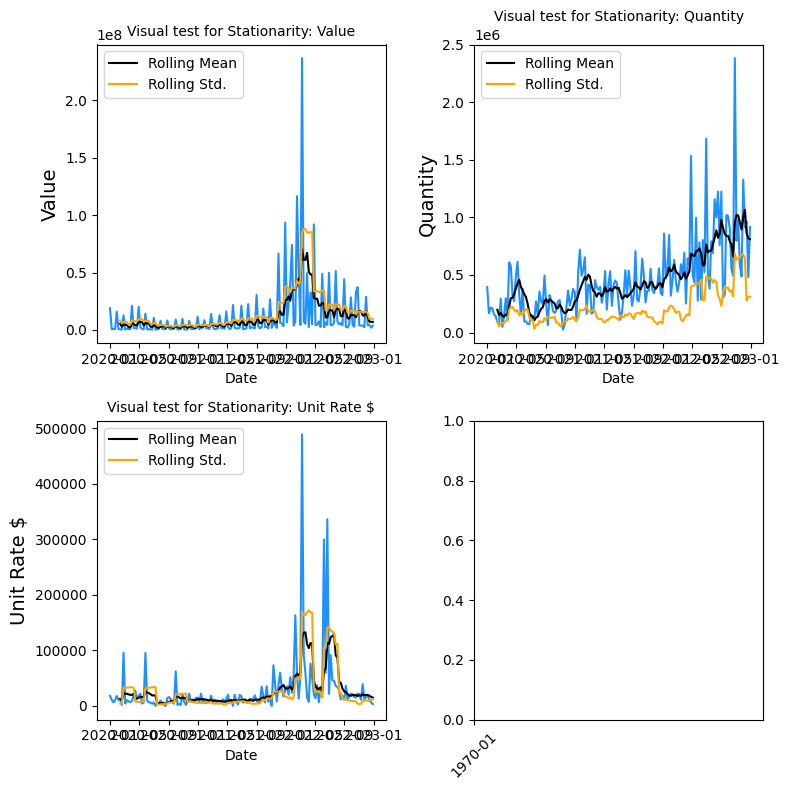

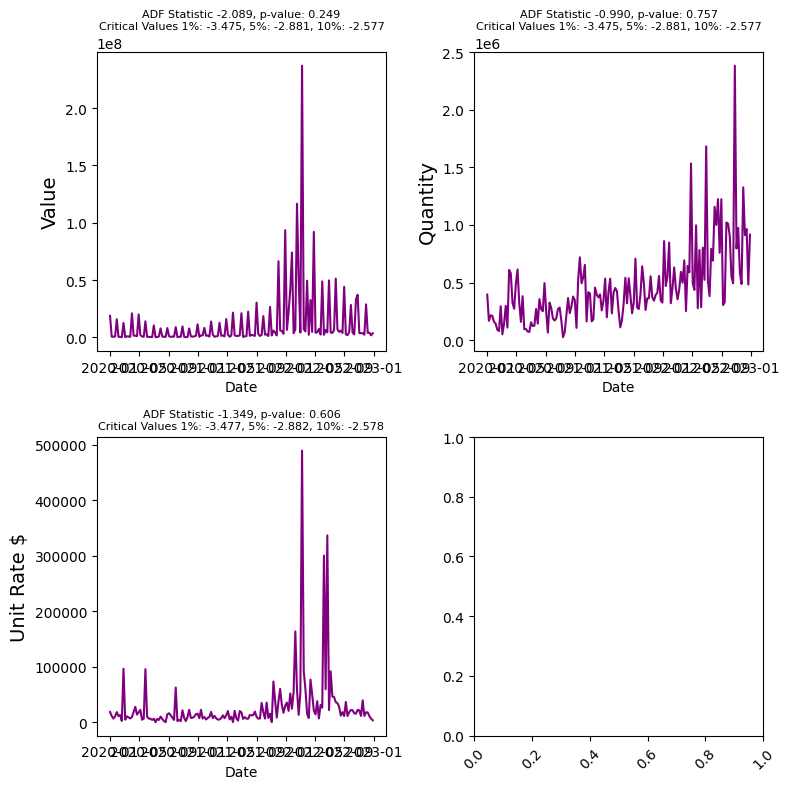

In [537]:
import math

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting time series for each metric and country
for country, group in grouped_data:
    # ======================================================
    # 2.1 Ensure equidistant timestamps 
    # ======================================================
    # Resample data and sum 'Value', 'Unit Rate $', and 'Quantity' in weekly increments
    weekly_data = group[['Value', 'Unit Rate $', 'Quantity']].resample('7D').sum()
    
    # ======================================================
    # 2.2 Stationarity
    # ======================================================
    # Check for stationarity. In other words, ensure:
    #   - constant mean and mean is not time-dependent
    #   - constant variance and variance is not time-dependent
    #   - constant covariance and covariance is not time-dependent

    # 2.2.1 Visual Test for Stationarity ===================
    rolling_window = 7
    width = height = math.ceil(math.sqrt(len(NUMERIC_COLUMNS)))
    f, ax = plt.subplots(nrows=width, ncols=height, figsize=(width * 4, height * 4))

    for index, numeric_column in enumerate(NUMERIC_COLUMNS):
        plot_graph_with_mean(
            data=weekly_data, 
            column_name=numeric_column,
            ax=ax[index % width, index // height], 
            rolling_window=7,
        )

    plt.tight_layout()
    plt.show()
    
    # 2.2.2 Augmented Dickey-Fuller for Stationarity ===================
    # Augmented Dickey-Fuller is a type of statistical test called a unit root test. 
    # Unit roots are a cause for non-stationarity.
    # 
    # Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).
    # Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(width * 4, height * 4))
    for index, numeric_column in enumerate(NUMERIC_COLUMNS):
        visualize_adfuller_results(
            weekly_data, 
            weekly_data[numeric_column].values,
            numeric_column,
            ax=ax[index % width, index // height], 
        )
    
    plt.tight_layout()
    plt.show()

##### **2.1 Differencing**
A method to transform a series into a stationary one (or at least attempt to).
It does so by subtracting current value from previous ones.
Used in autocorrelation later in Section 4.

In [538]:
def differencing(data):
    for column in NUMERIC_COLUMNS:
        ts_diff = np.diff(data[column])
        data[f'{column}_diff_1'] = np.append([0], ts_diff)
    return data

#### **2.2 Scale and Transform**
This is for modelling later on since our variance in data is quite large

In [539]:
from sklearn.preprocessing import MinMaxScaler

def scale_and_log_transform(data):
    # Convert to numeric and drop NaNs
    data_numeric = pd.to_numeric(data, errors='coerce').dropna()

    # Apply log transformation and replace -inf with NaN
    data_log = np.log(data_numeric.replace(0, np.nan))

    # Drop NaN values that resulted from log transformation
    data_log = data_log.dropna()

    # Apply Min-Max scaling
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_log.values.reshape(-1, 1)).flatten()
    return data_scaled, scaler



#### **2.3 Inverse Scaling and Trasformation**
This is to make performance metrics more accurate

In [540]:
def inverse_scale_and_exp_transform(scaled_data, scaler):
    data_inverse_scaled = scaler.inverse_transform(scaled_data.reshape(-1, 1)).flatten()
    data_original = np.exp(data_inverse_scaled)
    return data_original

### **3. Feature Engineering**
##### **3.1 Encode time**
Encode time-related features like year, month, etc

In [541]:
import pandas as pd

def encode_time_features(data):
    data['year'] = pd.DatetimeIndex(data.index).year
    data['month'] = pd.DatetimeIndex(data.index).month
    data['day'] = pd.DatetimeIndex(data.index).day
    data['day_of_year'] = pd.DatetimeIndex(data.index).dayofyear
    data['week_of_year'] = data.index.isocalendar().week
    data['quarter'] = pd.DatetimeIndex(data.index).quarter
    data['season'] = data['month'] % 12 // 3 + 1
    return data

##### **3.2 Encode Cyclical Features**
The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

In [542]:
import seaborn
import matplotlib.pyplot as plt
import numpy as np

def encode_cyclical_features(data):
    month_in_year = 12
    data['month_sin'] = np.sin(2*np.pi*data['month']/month_in_year)
    data['month_cos'] = np.cos(2*np.pi*data['month']/month_in_year)
    return data

##### **3.3 Time Series Decomposition**

In [543]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_time_series(data):
    for column in NUMERIC_COLUMNS:
        decomp = seasonal_decompose(data[column].dropna(), period=7, model='additive', extrapolate_trend='freq')
        decomp.trend
        data[f"{column}_Trend"] = decomp.trend
        data[f"{column}_Seasonal"] = decomp.seasonal
    return data
    

##### **3.4 Lag**

In [544]:
weeks_in_month = 4

# Store the names of all the shifted columns in an array (This will be used later)
SHIFTED_COLS = ['Value']
def encode_lag(data):
    for column in NUMERIC_COLUMNS:
        data[f'{column}_Seasonal_shift_b_2m'] = data[f'{column}_Seasonal'].shift(-2 * weeks_in_month)
        data[f'{column}_Seasonal_shift_b_1m'] = data[f'{column}_Seasonal'].shift(-1 * weeks_in_month)
        data[f'{column}_Seasonal_shift_1m'] = data[f'{column}_Seasonal'].shift(1 * weeks_in_month)
        data[f'{column}_Seasonal_shift_2m'] = data[f'{column}_Seasonal'].shift(2 * weeks_in_month)
        data[f'{column}_Seasonal_shift_3m'] = data[f'{column}_Seasonal'].shift(3 * weeks_in_month)

        SHIFTED_COLS.append(f'{column}_Seasonal_shift_b_2m')
        SHIFTED_COLS.append(f'{column}_Seasonal_shift_b_1m')
        # SHIFTED_COLS.append(f'{column}_Seasonal_shift_1m')
        # SHIFTED_COLS.append(f'{column}_Seasonal_shift_2m')
        # SHIFTED_COLS.append(f'{column}_Seasonal_shift_3m')
    return data

China


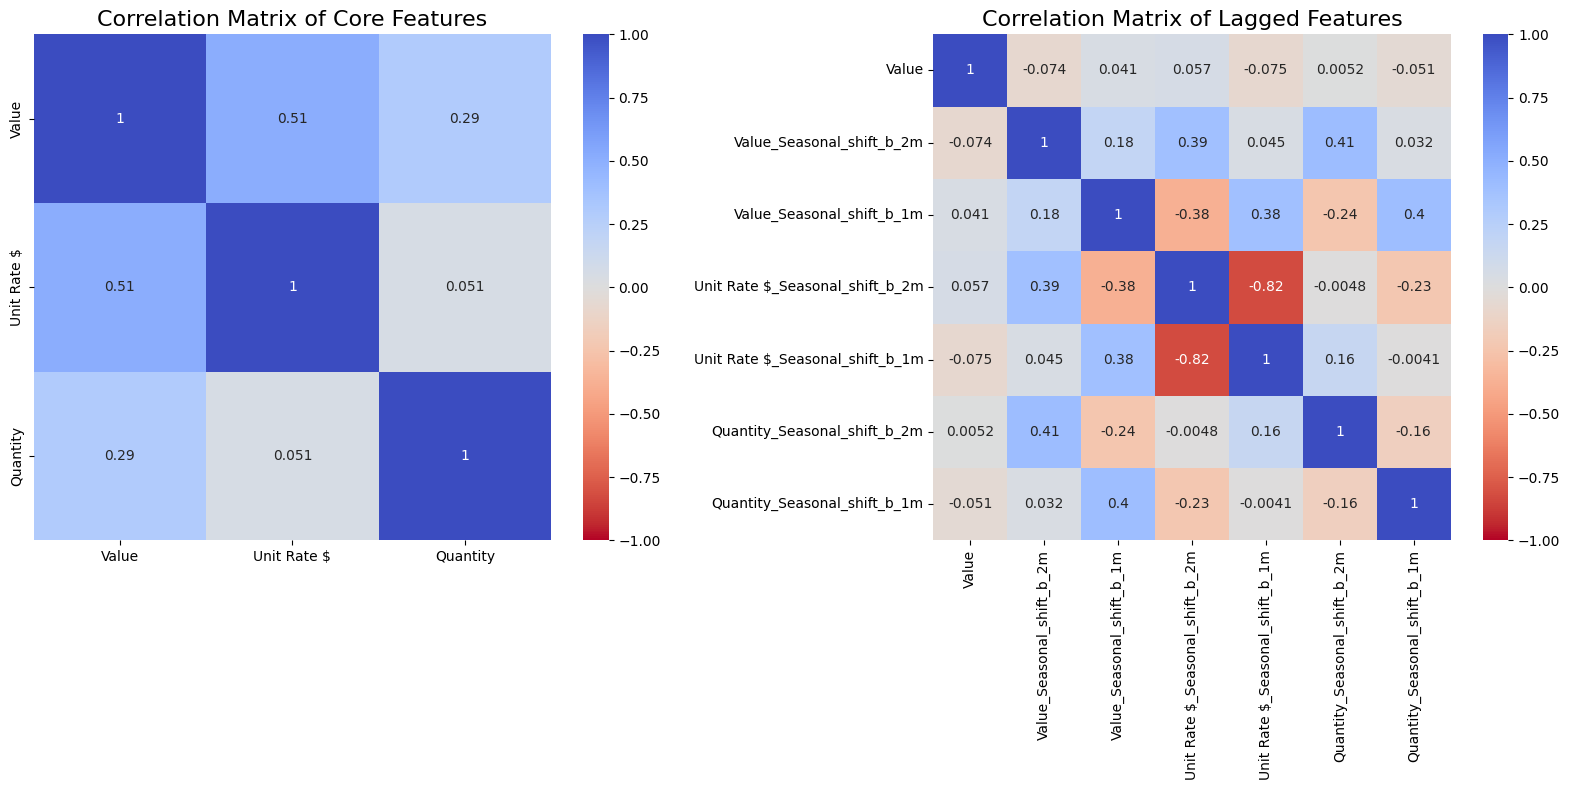

In [545]:

# Plotting time series for each metric and country
for country, group in grouped_data:
    
    # ======================================================
    # 3. Data Preprocessing
    # ======================================================
    print(country)

    weekly_data = group[['Value', 'Unit Rate $', 'Quantity']].resample('7D').sum()
    weekly_data = encode_time_features(weekly_data)
    weekly_data = encode_cyclical_features(weekly_data)
    weekly_data = decompose_time_series(weekly_data)
    weekly_data = encode_lag(weekly_data)

    # ======================================================
    # 4. Data Analysis
    # ======================================================
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    corrmat = weekly_data[NUMERIC_COLUMNS].corr()

    sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
    ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

    corrmat = weekly_data[SHIFTED_COLS].corr()

    sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
    ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


    plt.tight_layout()
    plt.show()

### **4. Data Analysis**
#### **4.1 Autocorrelation Analysis**

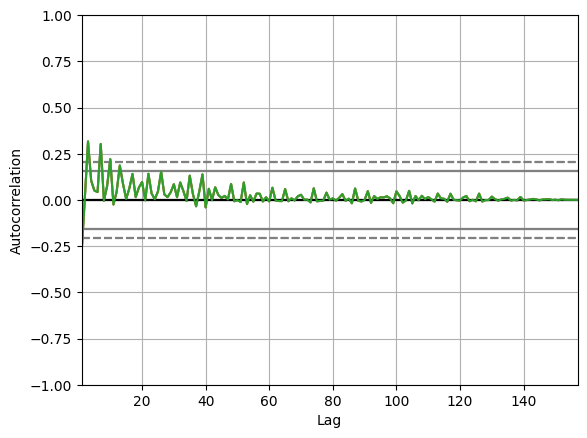

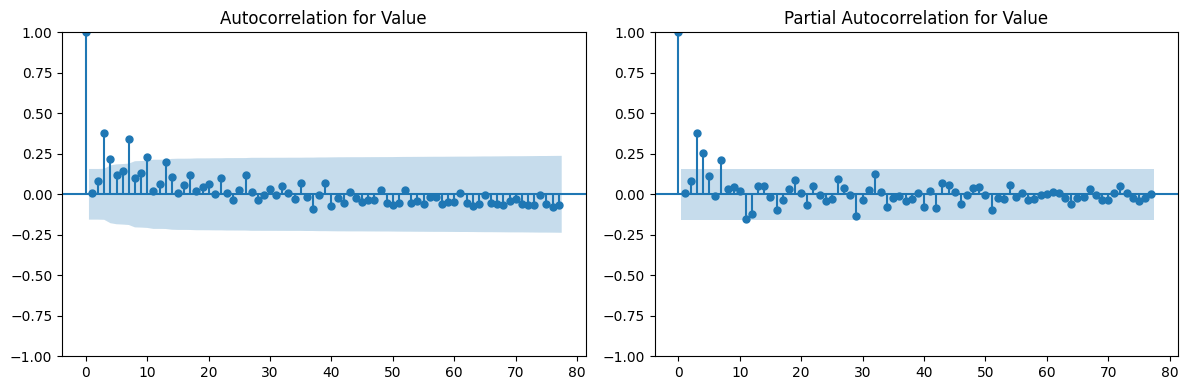

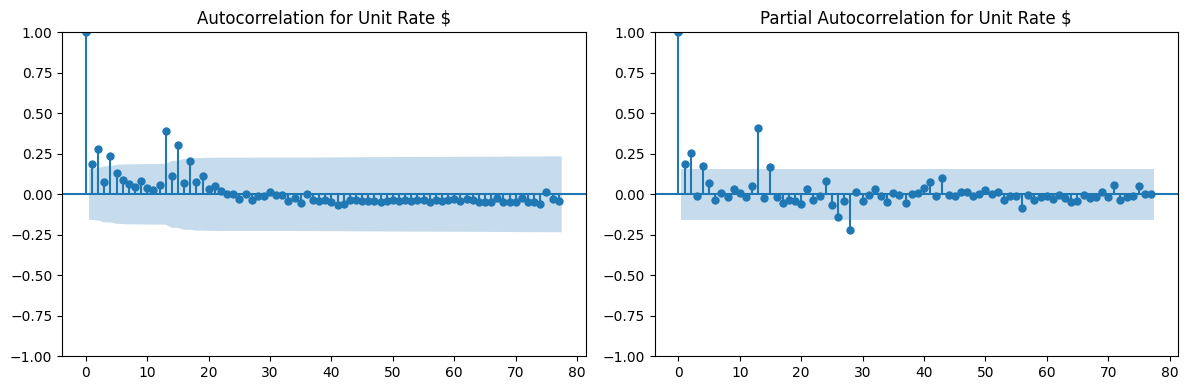

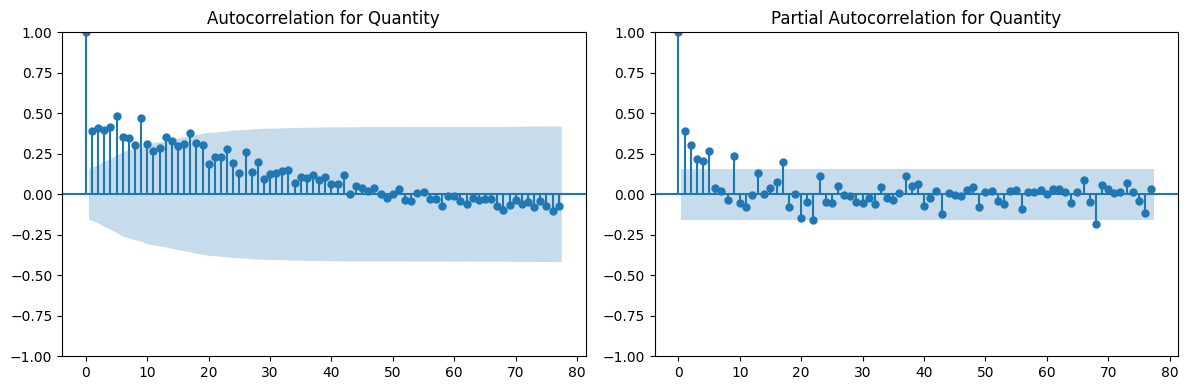

In [546]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Plotting time series for each metric and country
for country, group in grouped_data:

    # Resample data and sum 'Value', 'Unit Rate $', and 'Quantity' in weekly increments
    weekly_data = group[['Value', 'Unit Rate $', 'Quantity']].resample('7D').sum()
    # Differencing the data to make it stationary before plotting for autocorrelation
    weekly_data = differencing(weekly_data)

    for numeric_column in enumerate(NUMERIC_COLUMNS):
        autocorrelation_plot(weekly_data)
        
    plt.show()

    # f, ax = plt.subplots(nrows=2, ncols=len(NUMERIC_COLUMNS), figsize=(16, 8))

    for numeric_column in NUMERIC_COLUMNS:
        # Calculate maximum allowable lags (50% of the sample size)
        max_lags = len(weekly_data[numeric_column].dropna()) // 2 - 1
        max_lags = min(max_lags, 100)  # Limit to 100 if the series is very long

        # Create a new figure for each numeric column
        f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

        # Plot Autocorrelation
        plot_acf(weekly_data[numeric_column].dropna(), lags=max_lags, ax=ax[0])
        ax[0].set_title(f"Autocorrelation for {numeric_column}")

        # Plot Partial Autocorrelation
        plot_pacf(weekly_data[numeric_column].dropna(), lags=max_lags, ax=ax[1])
        ax[1].set_title(f"Partial Autocorrelation for {numeric_column}")

        plt.tight_layout() 
        plt.show()


### **5. Modelling**
#### **5.1 Performance Metrics**

In [547]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def performance_check(y_valid, y_pred):
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(f'RMSE: {rmse}')

    # Calculate MAE
    mae = mean_absolute_error(y_valid, y_pred)
    print(f'MAE: {mae} ')

    # Calculate R2
    r_squared = r2_score(y_valid, y_pred)
    print(f'R-squared: {r_squared}')

#### **5.2 Auto ARIMA Evaluation**

In [548]:
import pmdarima as pm
def evaluate_arima(y_train, y_valid, p, q):
    # Ensure y_train is a Series
    if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
        y_train = y_train.iloc[:, 0]
    
    # Ensure y_valid is a Series
    if isinstance(y_valid, pd.DataFrame) and y_valid.shape[1] == 1:
        y_valid = y_valid.iloc[:, 0]

    y_train_scaled, scaler = scale_and_log_transform(y_train)

    model = pm.auto_arima(y_train_scaled, start_p=1, start_q=1,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=p, max_q=q, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

    print(model.summary())

    model.plot_diagnostics(figsize=(16,8))
    plt.show()

    y_valid_scaled = scale_and_log_transform(y_valid)[0]  # Using only the scaled data

    print(f'Original y train: {y_train}')
    print(f'Scaled y train: {y_train_scaled}')
    print(f'Original y validation: {y_valid}')
    print(f'Scaled y validation: {y_valid_scaled}')
    print(f'Mean y train: {y_train.mean()}')
    print(f'Mean y valid: {y_valid.mean()}')

    # Make predictions
    y_pred_scaled = model.predict(n_periods=len(y_valid_scaled))
    print(f'Predicted y: {y_pred_scaled}')

    # Inverse transform predictions and validation data for performance check
    y_pred = inverse_scale_and_exp_transform(y_pred_scaled, scaler)
    y_valid_original = inverse_scale_and_exp_transform(y_valid_scaled, scaler)

    # Performance metrics
    performance_check(y_valid_original, y_pred)


    # Create a plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_valid_original, label='Actual', color='blue', marker='o')
    plt.plot(y_pred, label='Predicted', color='red', marker='x')

    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Data Points')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

#### **5.3 Multivariate Moddeling**

1096
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1602.925, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1457.900, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1063.751, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=661.816, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1603.136, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1601.485, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1603.551, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=172.035, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1601.338, Time=0.43 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-124.748, Time=0.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1567.190, Time=0.49 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]  

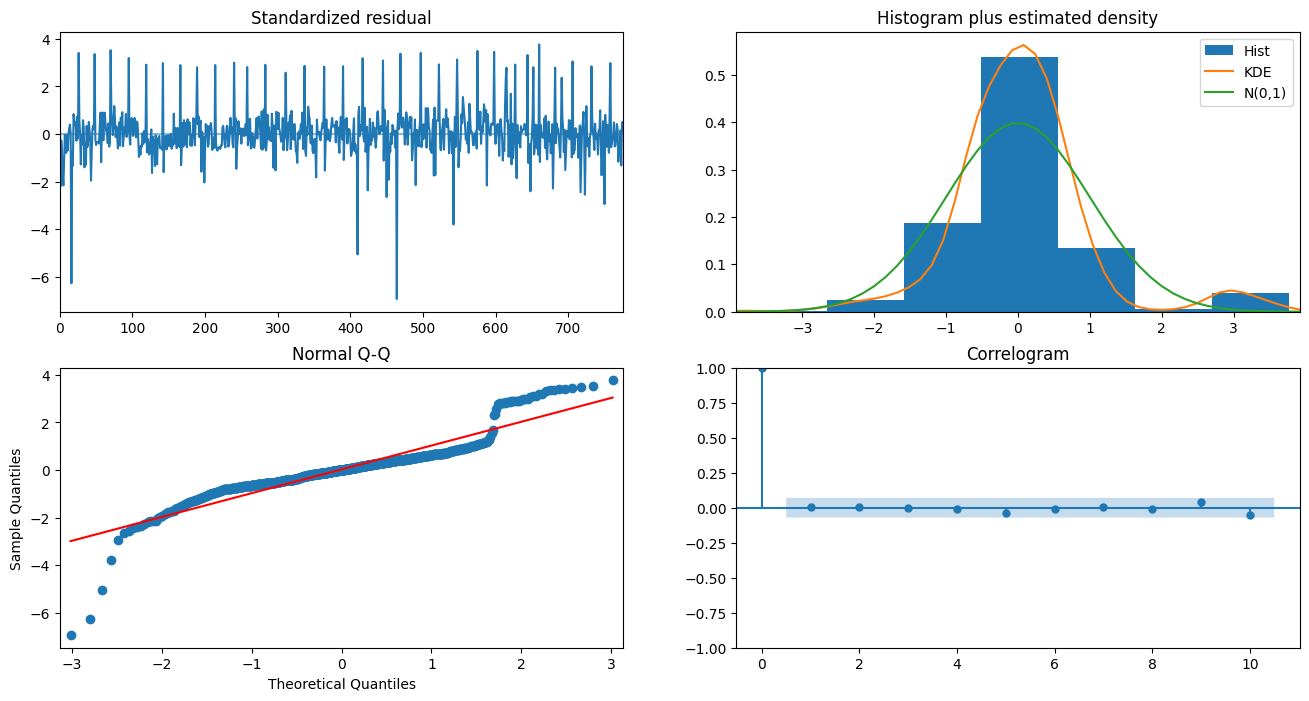

Original y train: 0        17447462.07
1          112499.98
2      874407.619695
3       295059.66043
4            44200.0
           ...      
926         712750.0
927          70389.0
928        1088883.0
929       1055373.82
930        609031.91
Name: Value, Length: 931, dtype: object
Scaled y train: [0.85410413 0.57012786 0.68557599 0.62441356 0.51753095 0.45631831
 0.52627763 0.60396039 0.53408609 0.52725166 0.58685665 0.52627763
 0.5876229  0.60338674 0.61623952 0.58655783 0.0416039  0.51889952
 0.43671551 0.62086589 0.5898698  0.58911587 0.57385498 0.52613677
 0.6153624  0.5341526  0.84668863 0.59434702 0.56556933 0.45860288
 0.56624119 0.52613677 0.61380532 0.57904196 0.44365504 0.53417291
 0.44974745 0.58978728 0.50777853 0.53216281 0.5976195  0.56631272
 0.52561114 0.38847545 0.4990885  0.56737686 0.57529374 0.5629278
 0.8342712  0.52123455 0.51916294 0.52906556 0.52838692 0.52838692
 0.52075912 0.58369924 0.62767371 0.45008643 0.60456897 0.62846938
 0.52932441 0.61833278 0.6

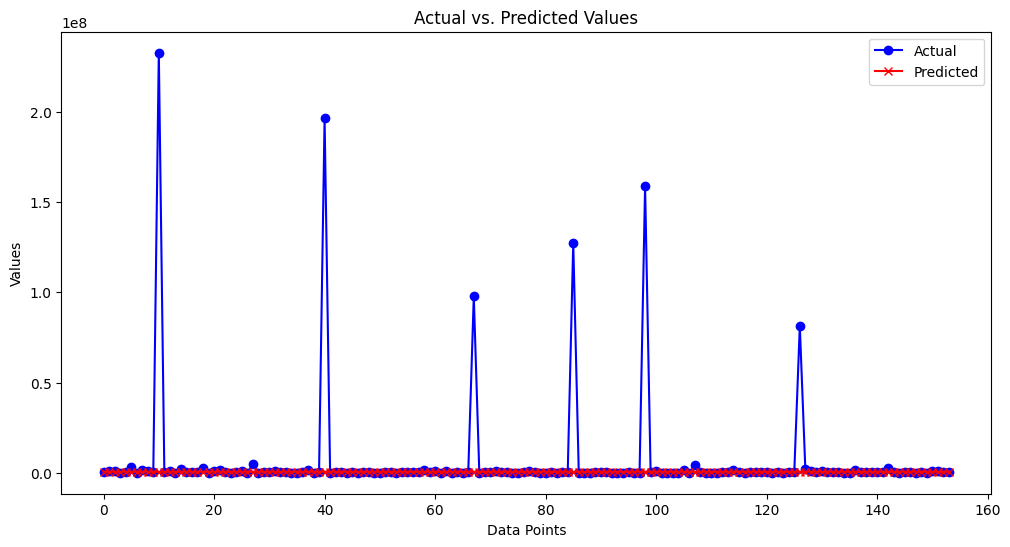

In [549]:
FEATURE_COLUMNS = ['Unit Rate $', 'Quantity']
TARGET_COLUMN = 'Value'

# Plotting time series for each metric and country
for country, group in grouped_data:

    # Resample data and sum 'Value', 'Unit Rate $', and 'Quantity' in weekly increments
    weekly_data = group[['Value', 'Unit Rate $', 'Quantity']].resample('D').sum()
    print(len(weekly_data))

    train_size = int(0.85 * len(weekly_data))

    multivariate_df = weekly_data.reset_index()
    multivariate_df.columns = ['ds', TARGET_COLUMN] + FEATURE_COLUMNS

    # Split into train and validation sets
    train_size = int(0.85 * len(multivariate_df))
    train = multivariate_df.iloc[:train_size, :]
    x_train, y_train = train.drop(TARGET_COLUMN, axis=1), train[TARGET_COLUMN]
    x_valid, y_valid = multivariate_df.iloc[train_size:].drop(TARGET_COLUMN, axis=1), multivariate_df.iloc[train_size:][TARGET_COLUMN]

evaluate_arima(y_train, y_valid, 7, 7)

#### **5.4 Univariate Modelling**

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7479.779, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6099.274, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2643.907, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7486.832, Time=0.83 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-7515.214, Time=1.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-7483.694, Time=1.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7485.181, Time=1.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-7594.111, Time=1.57 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7588.398, Time=1.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-7558.795, Time=0.64 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-7594.014, Time=2.61 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : A

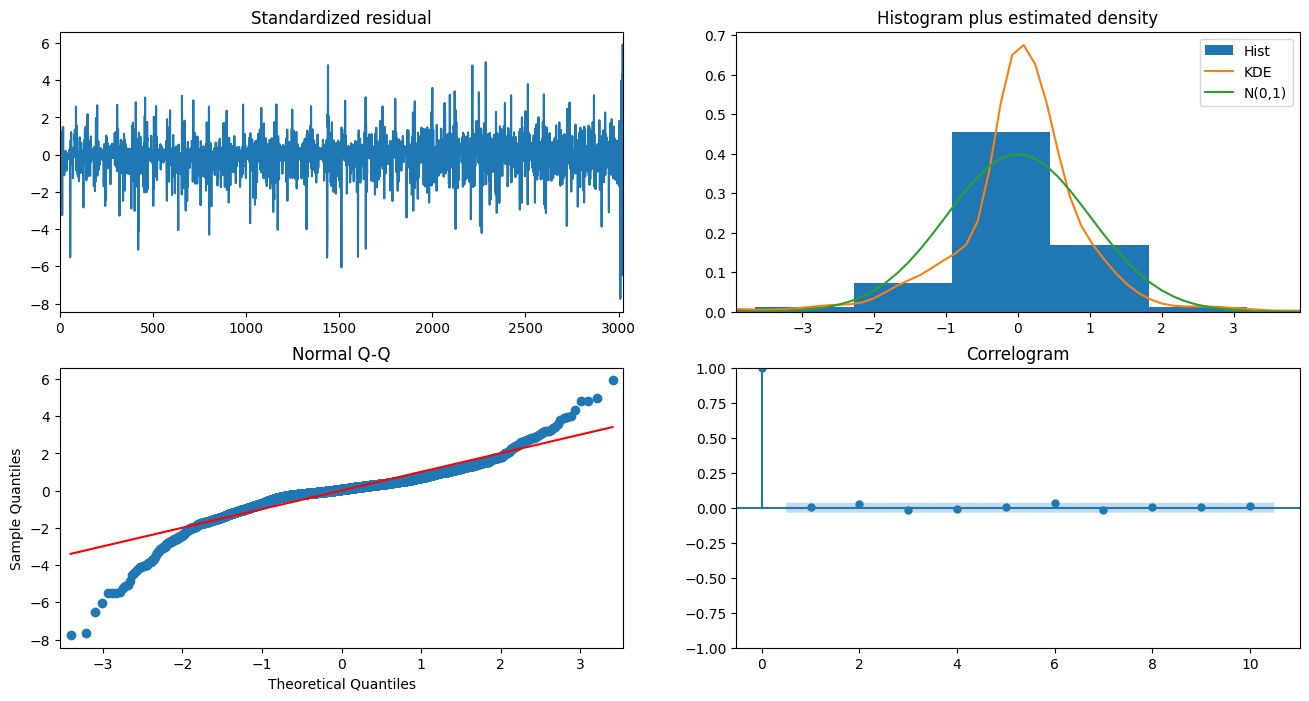

Original y train: 0       10015044.94
1              <NA>
2         215385.39
3              <NA>
4        2443624.72
           ...     
3382    22607930.69
3383      313742.57
3384     4872346.53
3385     1827267.33
3386      349712.87
Name: y, Length: 3387, dtype: object
Scaled y train: [0.86479196 0.69972637 0.80414665 ... 0.8338154  0.79165044 0.72056407]
Original y validation: 3387     224100.0
3388     101025.0
3389    5454255.0
3390      93544.0
3391     102600.0
          ...    
3980      65020.0
3981      82125.0
3982     80709.47
3983     148000.0
3984      87625.0
Name: y, Length: 598, dtype: object
Scaled y validation: [0.64446753 0.58696051 0.87486817 0.58140731 0.58807712 0.74874521
 0.73881485 0.80854828 0.70887852 0.66294798 0.76180635 0.59102362
 0.58888164 0.29972756 0.64219359 0.50115887 0.5812652  0.55356142
 0.46117713 0.57277529 0.2652758  0.36270177 0.61318871 0.35640994
 0.54137747 0.42693108 0.31403866 0.50249251 0.36814044 0.35722841
 0.57438771 0.54587865 0

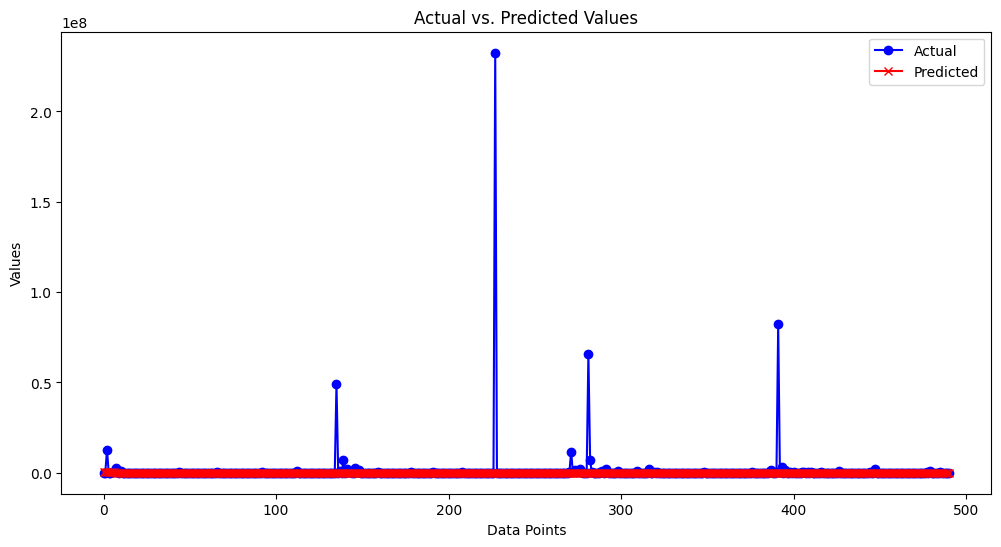

In [550]:
for country, group in grouped_data:
    # Assuming each group has a date-like index
    train_size = int(0.85 * len(group))
    test_size = len(group) - train_size

    univariate_df = group[['Value']].copy()
    univariate_df.reset_index(inplace=True)  # Resetting index to get date column
    univariate_df.columns = ['ds', 'y']  # Renaming columns for clarity

    train = univariate_df.iloc[:train_size, :]
    x_train, y_train = pd.DataFrame(train['ds']), pd.DataFrame(train['y'])
    x_valid, y_valid = pd.DataFrame(univariate_df.loc[train_size:, 'ds']), pd.DataFrame(univariate_df.loc[train_size:, 'y'])

evaluate_arima(y_train, y_valid, 3, 3)

#### **5.3 Random Forest**

#### **5.4 Gradient Boosting Machines**